## Run this notebook

You can launch this notbook using mybinder, by clicking the button below.

<a href="https://binder.openveda.cloud/v2/gh/NASA-IMPACT/veda-docs/HEAD?labpath=user-guide/notebooks/quickstarts%2Ftimeseries-stac-api.ipynb">
<img src="https://binder.openveda.cloud/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

   1. Using a list of STAC items and a bouding box fetch stats from `/cog/statistics` endpoint
   2. Generate a timeseries plot using statistics from each time step
   3. Speed up workflow using Dask


In [1]:
import json
import sys
import requests
import folium
import shapely

import pandas as pd
import matplotlib.pyplot as plt

## Declare your collection of interest

You can discover available collections the following ways:

* Programmatically: see example in the `list-collections.ipynb` notebook
* JSON API: https://openveda.cloud/api/stac/collections
* STAC Browser: https://openveda.cloud

In [2]:
STAC_API_URL = "https://openveda.cloud/api/stac"
RASTER_API_URL = "https://openveda.cloud/api/raster"

collection_id = "no2-monthly"

## Fetch STAC collection

We will use `requests` to fetch all the metadata about the collection of interest from STAC.

In [3]:
response = requests.get(f"{STAC_API_URL}/collections/{collection_id}")

assert response.ok, response.text

collection = response.json()
collection

{'id': 'no2-monthly',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://openveda.cloud/api/stac/collections/no2-monthly/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://openveda.cloud/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://openveda.cloud/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://openveda.cloud/api/stac/collections/no2-monthly'},
  {'rel': 'http://www.opengis.net/def/rel/ogc/1.0/queryables',
   'type': 'application/schema+json',
   'title': 'Queryables',
   'href': 'https://openveda.cloud/api/stac/collections/no2-monthly/queryables'}],
 'title': 'NO₂',
 'assets': {'thumbnail': {'href': 'https://thumbnails.openveda.cloud/no2--dataset-cover.jpg',
   'type': 'image/jpeg',
   'roles': ['thumbnail'],
   'title': 'Thumbnail',
   'description': 'Photo by [Mick Truyts](https://unsplash.com/photos/x6WQeNYJC1w) (Power plant shoot

### Describe the periodic nature of the data

In the collection above we will pay particular attention to the fields that define the periodicity of the data.

In [4]:
collection["dashboard:is_periodic"]

True

In [5]:
collection["dashboard:time_density"]

'month'

In [6]:
collection["summaries"]

{'datetime': ['2016-01-01T00:00:00Z', '2023-09-30T00:00:00Z']}

## Fetch STAC items

Get the list of all the STAC items within this collection.

In [7]:
response = requests.get(
    f"{STAC_API_URL}/collections/{collection_id}/items?limit=100"
)

assert response.ok, response.text

items = response.json()["features"]
len(items)

93

We can inspect one of these items to get a sense of what metadata is available.

In [8]:
items[0]

{'id': 'OMI_trno2_0.10x0.10_202309_Col3_V4.nc',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://openveda.cloud/api/stac/collections/no2-monthly'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://openveda.cloud/api/stac/collections/no2-monthly'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://openveda.cloud/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://openveda.cloud/api/stac/collections/no2-monthly/items/OMI_trno2_0.10x0.10_202309_Col3_V4.nc'},
  {'title': 'Map of Item',
   'href': 'https://openveda.cloud/api/raster/collections/no2-monthly/items/OMI_trno2_0.10x0.10_202309_Col3_V4.nc/map?bidx=1&assets=cog_default&rescale=0%2C15000000000000000&resampling=bilinear&color_formula=gamma+r+1.05&colormap_name=rdbu_r',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets': {'cog_default': {'href': 's3://veda-data-s

## Define an area of interest

We will be using a bounding box over metropolitan france. We'll use that bounding box to subset the data when calculating the timeseries.

In [9]:
france_bounding_box = {
    "type": "Feature",
    "properties": {"ADMIN": "France", "ISO_A3": "FRA"},
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [-5.183429, 42.332925],
                [8.233998, 42.332925],
                [8.233998, 51.066135],
                [-5.183429, 51.066135],
                [-5.183429, 42.332925],
            ]
        ],
    },
}

Let's take a look at that box.

In [10]:
m = folium.Map(
    location=[40, 0],
    zoom_start=3,
)

folium.GeoJson(france_bounding_box, name="France").add_to(m)
m

## Use `/statistics` to get data for the AOI

First, we create a `generate_stats` function and then we call it with the bounding box defined for France. 

NOTE: The RASTER_API expects AOI as a `Feature` or a `FeatureCollection`. The datatype of the input matches the datatype of the output. So if you use a `FeatureCollection` as input, you will get back a `FeatureCollection`.

In [11]:
def generate_stats(item, geojson):
    """ Generate statistics for a particular item and AOI

    NOTE: This function assumes that the AOI is a geojson `Feature`.
    """
    response = requests.post(
        f"{RASTER_API_URL}/collections/{collection_id}/items/{item['id']}/statistics",
        json=geojson
    )
    assert response.ok, response.text
    return {
        **response.json()["properties"]["statistics"]["cog_default_b1"],
        "start_datetime": item["properties"]["start_datetime"],
    }

Let's run this function on a single item to get a sense of the output

In [12]:
%%time

generate_stats(items[0], france_bounding_box)

CPU times: user 4.47 ms, sys: 0 ns, total: 4.47 ms
Wall time: 388 ms


{'min': -387779578036224.0,
 'max': 5971174383157248.0,
 'mean': 1636077207936257.2,
 'count': 11880.0,
 'sum': 1.9436597230282736e+19,
 'std': 808762440624020.6,
 'median': 1506456557846528.0,
 'majority': 1143241374171136.0,
 'minority': -387779578036224.0,
 'unique': 11875.0,
 'histogram': [[120, 1616, 4274, 3441, 1384, 624, 244, 125, 40, 12],
  [-387779578036224.0,
   248115831504896.0,
   884011241046016.0,
   1519906650587136.0,
   2155802060128256.0,
   2791697603887104.0,
   3427592744992768.0,
   4063488422969344.0,
   4699383564075008.0,
   5335279242051584.0,
   5971174383157248.0]],
 'valid_percent': 100.0,
 'masked_pixels': 0.0,
 'valid_pixels': 11880.0,
 'percentile_2': 395780397465600.0,
 'percentile_98': 3847018581590016.0,
 'start_datetime': '2023-09-01T00:00:00+00:00'}

### Generate stats

This may take some time due to the complexity of the shape we're requesting. See the end of this notebook for tips on how to speed this up.

In [13]:
%%time
stats = [generate_stats(item, france_bounding_box) for item in items]

CPU times: user 306 ms, sys: 24.6 ms, total: 330 ms
Wall time: 36.7 s


## Plot timeseries

It is easier to interact with these results as a pandas dataframe so create one from the list of dicts.

In [14]:
df = pd.DataFrame(stats)

Convert the `start_datetime` column to real pandas datetime dtype:

In [15]:
df["date"] = pd.to_datetime(df["start_datetime"])

### Construct the plot

Text(0.5, 1.0, 'NO2 Values in France (2016-2022)')

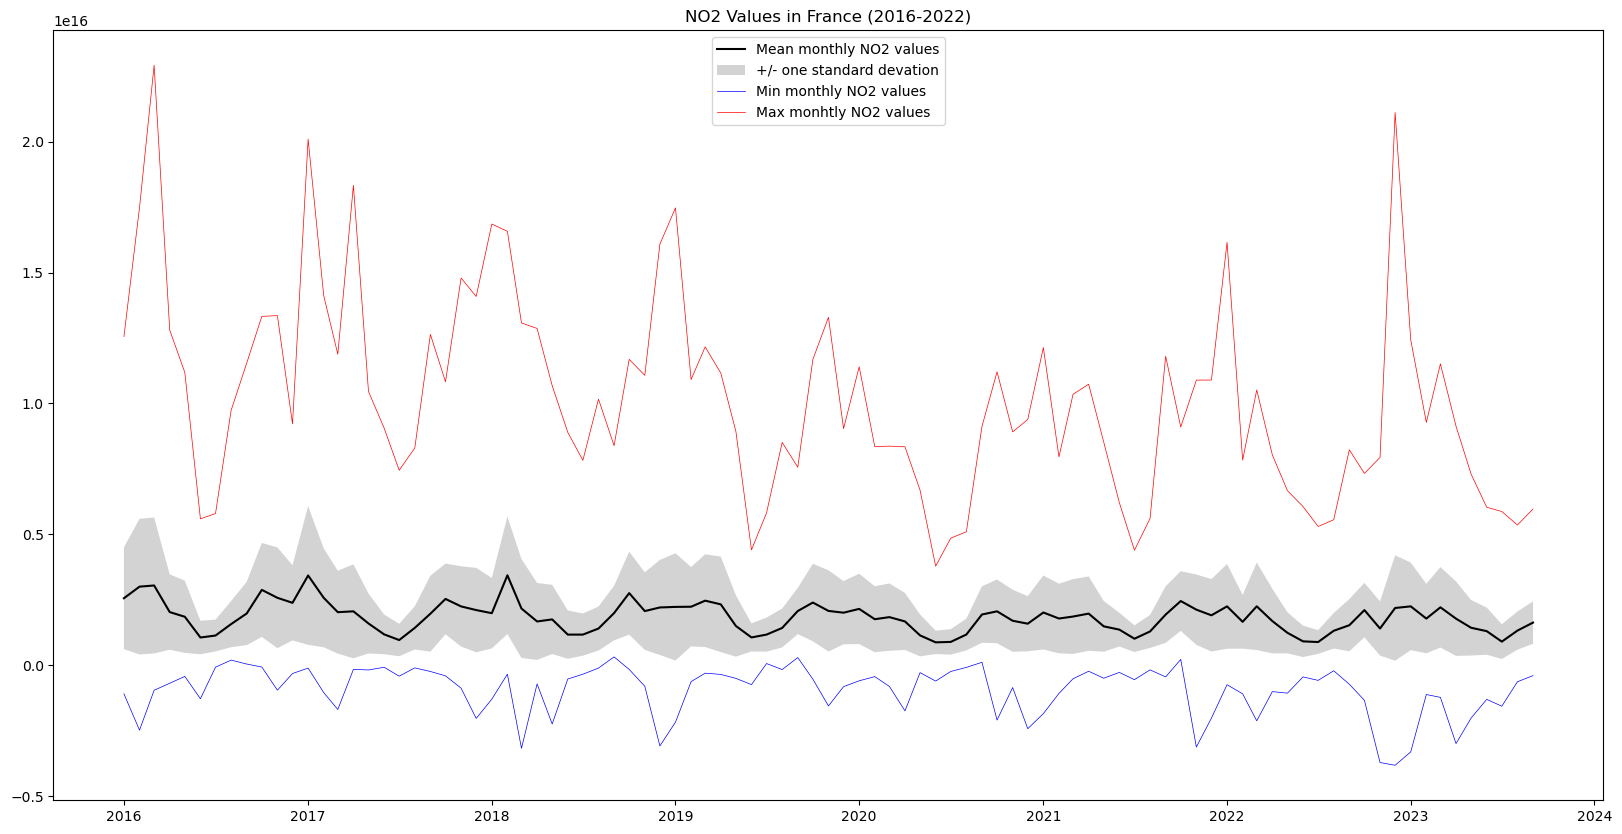

In [16]:
fig = plt.figure(figsize=(20, 10))

plt.plot(df["date"], df["mean"], "black", label="Mean monthly NO2 values")

plt.fill_between(
    df["date"],
    df["mean"] + df["std"],
    df["mean"] - df["std"],
    facecolor="lightgray",
    interpolate=False,
    label="+/- one standard devation",
)

plt.plot(
    df["date"],
    df["min"],
    color="blue",
    linestyle="-",
    linewidth=0.5,
    label="Min monthly NO2 values",
)
plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max monhtly NO2 values",
)

plt.legend()
plt.title("NO2 Values in France (2016-2022)")

In this graph we can see the yearly cycles in NO2 values due to seasonal variations, as well as a slight downward slope in maximum NO2 values

## Complex AOI

The values plotted above don’t correspond exactly to Fance, since the bounding box excludes Corsica and overseas territories such as Mayotte and French Polynesia, and covers parts of neighboring countries including Spain, Italy, Germany and the entirety of Luxembourg. We can fetch GeoJSON from an authoritative online source (https://gadm.org/download_country.html).

While the NO2 values above correspond _more or less_ to those of in France, we can be much more precise by using a  complex geojson that represents the boundaries of France exactly, including overseas territories in the Carribean and Indian Oceans, and South America.

Note: In this notebook we write out the whole perimeter as a `MultiPolygon` in geojson. In practice you will often be reading this kind of shape from a file (usually with the help of `geopandas`).

In [37]:
response = requests.get(
    "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/FRA/ADM0/geoBoundaries-FRA-ADM0.geojson"
)

# If anything goes wrong with this request output error contents
assert response.ok, response.text

result = response.json()
print(f"There are {len(result['features'])} features in this collection")

There are 1 features in this collection


That is the geojson for a feature collection, but since there is only one feature in it we can grab just that.

In [38]:
france_aoi = result["features"][0]

Let's take a look at this AOI on a map

In [39]:
m = folium.Map(
    location=[46, 0],
    zoom_start=5,
)

folium.GeoJson(france_aoi, name="France").add_to(m)
m

## Simplifying the AOI

You might notice that that is a highly detailed border. In fact it is so detailed that it is too big to pass to the Raster API. It will get rejected. The limit on the Raster API is 16 Kb. And our current AOI is roughly:

In [40]:
size = sys.getsizeof(json.dumps(france_aoi))
print(f"{size // 1024} Kb")

137 Kb


So can we simplify it? Naively let's try just using shapely's `.simplify` method:

In [21]:
france = shapely.from_geojson(json.dumps(france_aoi))
france_simplified = france.simplify(0.01)

size = sys.getsizeof(shapely.to_geojson(france_simplified))
print(f"{size // 1024} Kb")

54 Kb


Still too big... what if we increase the `tolerance`? Basically you can increase it as high as you want but you'll never get below the 16 Kb threshold because there are a ton of little islands. What if we applied a buffer and then unapplied it before simplifying:

In [22]:
france_simplified = (
    france
        .buffer(0.1).buffer(-0.1)
        .simplify(0.01)
)

size = sys.getsizeof(shapely.to_geojson(france_simplified))
print(f"{size // 1024} Kb")

21 Kb


That is getting better, but if we look at the coordinates we can see that they have a ton of precision that is unnecessary:

In [23]:
shapely.to_geojson(france_simplified)[:100]

'{"type":"MultiPolygon","coordinates":[[[[8.53443024461565,42.3723455953355],[8.626726724070997,42.43'

Maybe we can round all of those. 

In [24]:
france_simplified = shapely.set_precision(
    france
        .buffer(0.1).buffer(-0.1)
        .simplify(0.01), 
    0.0001
)

size = sys.getsizeof(shapely.to_geojson(france_simplified))
print(f"{size // 1024} Kb")

9 Kb


Let's make sure that AOI still looks decent:

In [25]:
m = folium.Map(
    location=[46, 0],
    zoom_start=5,
)

folium.GeoJson(france_simplified, name="France").add_to(m)
m

We can now request the NO2 values for this AOI the same way as for the bounding box. 

Notice, however, that due to the complexity of the shape (even the simplified shape), it takes a little longer to gather the requested data as for the bounding box example above.

In [26]:
france_new_aoi = {
    **france_aoi,
    "geometry": json.loads(shapely.to_geojson(france_simplified))
}

In [36]:
%%time

stats = [generate_stats(item, france_new_aoi) for item in items]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [28]:
aoi_df = pd.DataFrame(stats)
aoi_df["date"] = pd.to_datetime(aoi_df["start_datetime"])

We can compare the mean monthly NO2 values calculated when using the bounding box and when using the country's exact borders

Text(0.5, 1.0, 'NO2 Values in France (2016-2022)')

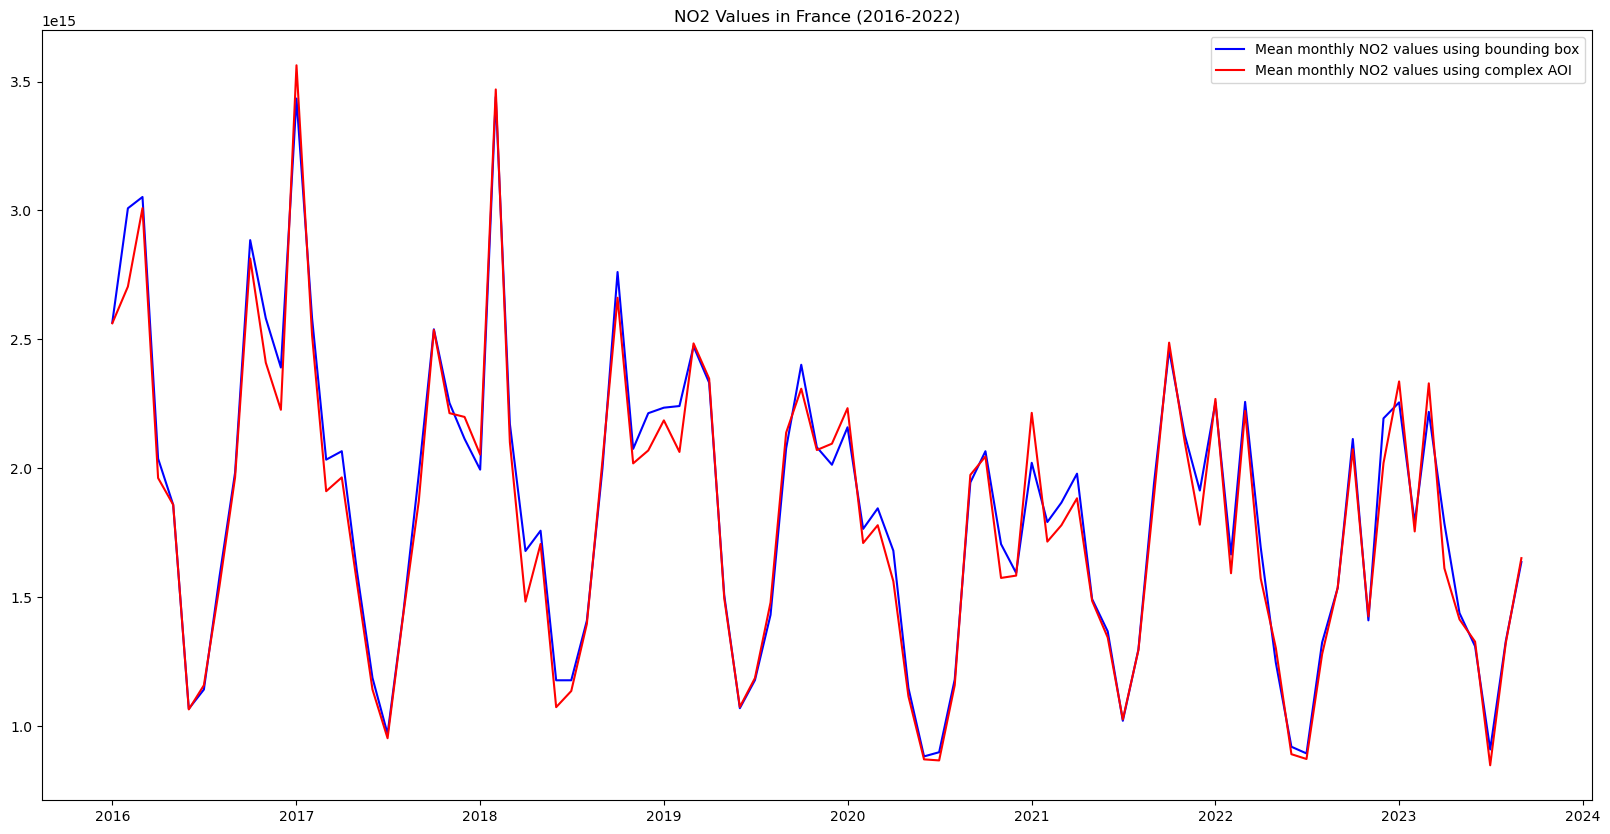

In [29]:
fig = plt.figure(figsize=(20, 10))

plt.plot(
    df["date"],
    df["mean"],
    color="blue",
    label="Mean monthly NO2 values using bounding box",
)
plt.plot(
    aoi_df["date"],
    aoi_df["mean"],
    color="red",
    label="Mean monthly NO2 values using complex AOI",
)

plt.legend()
plt.title("NO2 Values in France (2016-2022)")

While the difference is small, it is very interesting to note that the NO2 values calculated using the exact borders are systematically less than when using the bounding box. This may be due to the fact that the bounding box includes parts of western Germany and northern Italy that have a lot industrial activity, whereas the areas included when using the exact borders that are not included in the bounding box case, are overseas territories much less industrial activity. 

## Speed things up: parallelize computation with Dask

We can drastically reduce the time it takes to generate the timeseries, even with the complex AOI above, by parallelizing our code. The `cogs/statistics` API is powered by AWS Lambda which executes each request in a separate instance. This means the requests are highly scalable. Since each statistics request is for a single timestamp, we can request statistics for multiple timesteps concurrently, and greatly reduce the amount of time needed. We will demonstrate this by using the Dask.

### Submit work

First we will create a Dask client. In this case we will use the threads on the same server that is running this jupyter notebook. We will submit the `generate_stats` function for each item in our list and collect a list of futures. This will immediately kick off work in dask. We can then gather all the results.

In [30]:
%%time
import dask.distributed

with dask.distributed.Client() as client:
    futures = [client.submit(generate_stats, item, france_new_aoi) for item in items]
    stats = client.gather(futures)

CPU times: user 1.79 s, sys: 125 ms, total: 1.92 s
Wall time: 8.84 s


### Alternate approach

If you are familiar with the `concurrent.futures` library you can use that instead of Dask. Or you can use `httpx` instead of `requests` to fetch the statistics asynchronously.